## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

## Load Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

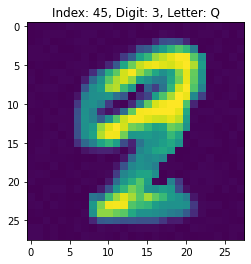

In [3]:
idx = 45
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## Train model

In [4]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [34]:
def create_cnn_model():
    inputs = Input(shape = (28,28,1))
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    do=tf.keras.layers.Dropout(0.5)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(do)
    

    
    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    do=tf.keras.layers.Dropout(0.5)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(do)

    
    
    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    do=tf.keras.layers.Dropout(0.5)(conv)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(do)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [35]:
create_cnn_model().summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization_104 (Bat (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization_105 (Bat (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 28, 28, 64)        16448     
_________________________________________________________________
dropout_39 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 14, 14, 64)        0  

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1
   # brightness_range=[0.8,1.2] #이걸조절하니까 다 1로예측함 ㅠㅠ
)

model = create_cnn_model()

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  datagen.flow(x_train, y_train, batch_size=16),
  epochs=200, 
  steps_per_epoch = x_train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 1s 8ms/step - loss: 3.8202 - accuracy: 0.2334 - lr: 0.0010
Epoch 2/200
128/128 [==============================] - 1s 8ms/step - loss: 2.8257 - accuracy: 0.3374 - lr: 9.5000e-04
Epoch 3/200
128/128 [==============================] - 1s 8ms/step - loss: 2.5206 - accuracy: 0.4048 - lr: 9.0250e-04
Epoch 4/200
128/128 [==============================] - 1s 8ms/step - loss: 2.3187 - accuracy: 0.4443 - lr: 8.5737e-04
Epoch 5/200
128/128 [==============================] - 1s 8ms/step - loss: 2.2180 - accuracy: 0.4810 - lr: 8.1451e-04
Epoch 6/200
128/128 [==============================] - 1s 8ms/step - loss: 2.0682 - accuracy: 0.5151 - lr: 7.7378e-04
Epoch 7/200
128/128 [==============================] - 1s 8ms/step - loss: 1.9362 - accuracy: 0.5610 - lr: 7.3509e-04
Epoch 8/200
128/128 [==============================] - 1s 8ms/step - loss: 1.7413 - accuracy: 0.6294 - lr: 6.9834e-04
Epoch 9/200
128/128 [==============================] - 1s 7m

Epoch 70/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4934 - accuracy: 0.9414 - lr: 2.9035e-05
Epoch 71/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4856 - accuracy: 0.9468 - lr: 2.7584e-05
Epoch 72/200
128/128 [==============================] - 1s 7ms/step - loss: 0.5008 - accuracy: 0.9419 - lr: 2.6205e-05
Epoch 73/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4802 - accuracy: 0.9463 - lr: 2.4894e-05
Epoch 74/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4968 - accuracy: 0.9424 - lr: 2.3650e-05
Epoch 75/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4934 - accuracy: 0.9453 - lr: 2.2467e-05
Epoch 76/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4882 - accuracy: 0.9409 - lr: 2.1344e-05
Epoch 77/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4865 - accuracy: 0.9473 - lr: 2.0277e-05
Epoch 78/200
128/128 [==========================

128/128 [==============================] - 1s 8ms/step - loss: 0.4353 - accuracy: 0.9561 - lr: 8.8743e-07
Epoch 139/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4449 - accuracy: 0.9541 - lr: 8.4306e-07
Epoch 140/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4207 - accuracy: 0.9580 - lr: 8.0091e-07
Epoch 141/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4601 - accuracy: 0.9478 - lr: 7.6086e-07
Epoch 142/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4327 - accuracy: 0.9580 - lr: 7.2282e-07
Epoch 143/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4520 - accuracy: 0.9536 - lr: 6.8668e-07
Epoch 144/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4359 - accuracy: 0.9624 - lr: 6.5234e-07
Epoch 145/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4351 - accuracy: 0.9556 - lr: 6.1973e-07
Epoch 146/200
128/128 [==============================]

## Predict

In [22]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)
submission.head(50)

,id,digit
0,2049,6
1,2050,5
2,2051,6
3,2052,8
4,2053,3
5,2054,8
6,2055,5
7,2056,3
8,2057,1
9,2058,4


In [15]:
submission.to_csv('epoch200_parm수정2.csv', index=False)